In [1]:
from data.config import *
from data.dataset import *
from report.dumps import *
from nn.model import model
from nn.funcs import *
import numpy as np

In [2]:
def test(ds, verbose=False, phase="Validation"):
    ds.reset()
    hits = 0
    mean_loss = 0
    while not(ds.iter_done()):
        x, y = ds.next()
        o, batch_loss = nn.forward(x, y, train=False)
        print(o)
        hits += batch_hits(o, y)
        mean_loss += np.mean(batch_loss)
        #if verbose:
        #    print("Loss: " + str(mean_loss), " Predicted: " + str(o), " Expected: " + str(y))
    accuracy = float(hits) / float(ds.size)
    mean_loss = float(mean_loss) / float(ds.size)
    if verbose:
        print(phase + " Accuracy: " + str(accuracy) + " Mean Loss " + str(mean_loss))
    return accuracy, mean_loss

In [3]:
def train(nn, hp, val_hist, train_hist, logger):
    cur_epoch = 1
    cur_iter = 1
    for i in range(1, hp.epochs+1):
        train_loss = 0
        hits = 0
        cur_trained = 0
        while not(hp.ds_train.iter_done()):
            x, y = hp.ds_train.next()
            #print(y)
            o, batch_loss = nn.forward(x, y)
            nn.backward(y,o)
            nn.update(hp.lr)

            hits += batch_hits(o, y)
            cur_trained += len(x)
            train_loss += np.mean(batch_loss)

            if cur_iter % hp.validate_every_no_of_batches == 0:

                train_accuracy = float(hits) / float(cur_trained)
                train_loss = float(train_loss) / float(cur_trained)
                train_hist.add(cur_iter, train_loss, train_accuracy)
                logger.write( (cur_epoch, "Training", cur_iter, train_accuracy, train_loss) )
                hits = 0
                train_loss = 0

                val_accuracy, val_loss = test(hp.ds_val, True)
                val_hist.add(cur_iter, val_loss, val_accuracy)
                logger.write( (cur_epoch, "Val", cur_iter, val_accuracy, val_loss) )
            cur_iter+=1
        cur_epoch+=1
        hp.ds_train.reset()
    return val_hist

[[0.30067521 0.20682448]
 [0.52810193 0.40678065]]
[[ 0.98705243  0.05232438]
 [ 0.45967725 -0.20351387]]
Validation Accuracy: 0.5 Mean Loss 0.30515276383436674
[[0.52520279 0.47169897]
 [0.34971216 0.17043859]]
[[0.28982802 0.6839911 ]
 [0.21679536 0.47526807]]
Validation Accuracy: 0.5 Mean Loss 0.19855549954609808
[[0.39723844 0.49718904]
 [0.68164624 0.50973082]]
[[0.30375693 0.71439482]
 [0.78321997 0.22201238]]
Validation Accuracy: 0.5 Mean Loss 0.1467528417432685
[[0.57000162 0.54978737]
 [0.39605733 0.51655111]]
[[0.33832586 0.6947862 ]
 [0.6253485  0.30257061]]
Validation Accuracy: 0.5 Mean Loss 0.13803713112813765
[[0.4432597  0.51413761]
 [0.21200875 0.64789289]]
[[0.63890829 0.28101913]
 [0.34843995 0.47908908]]
Validation Accuracy: 0.25 Mean Loss 0.09155527373974623
[[0.49491737 0.42143616]
 [0.40720624 0.43954071]]
[[0.55436101 0.26338095]
 [0.36339523 0.54330961]]
Validation Accuracy: 0.5 Mean Loss 0.1335373800187551
[[0.2933079  0.42206114]
 [0.4713312  0.42424196]]
[[0.

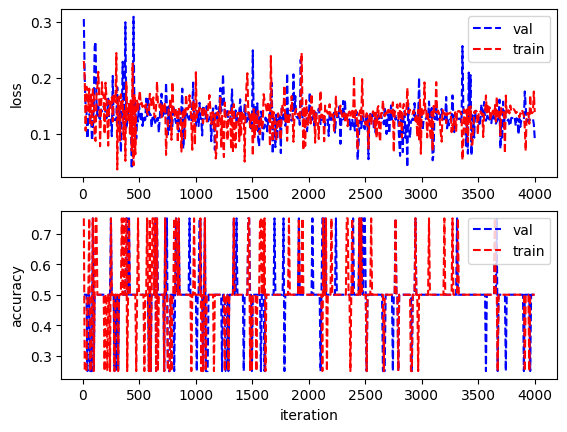

In [4]:
#load hyperparameters and settings according to dataset enum
hp = hyperparams(ConfigEnum.XOR)
#hp = hyperparams(ConfigEnum.IRIS)
# hp = hyperparams(ConfigEnum.MNIST)

#model has number of inputs, number of outputs, and list with sizes of hidden layers
#requires at least 1 hidden layer, else fails assert
nn = model(hp.input_size, hp.output_size, hp.hidden_shapes, tanh, tanh_grad, has_dropout=hp.has_dropout, dropout_perc=hp.dropout_perc)

val_hist = historian()
train_hist = historian()
logger = nnlogger(hp.output_log, ("Epoch", "Phase", "Iteration", "Accuracy", "Loss") )
train(nn, hp, val_hist, train_hist, logger)
test(hp.ds_test, verbose=True, phase="Test")
nnplotter.view(val_hist, train_hist) #see results on plot
logger.close()